In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate, optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner
import emcee
import time
import dynesty

C:\Users\Admin\anaconda3\lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


# MCMC

In [2]:
data = np.load(r"C:\Users\Admin\reps\astrostatistics_bicocca_2024\solutions\transient.npy")

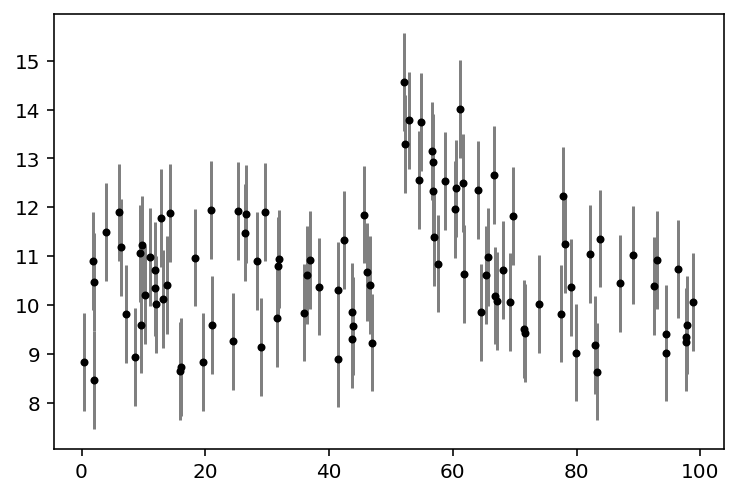

In [3]:
time = data[:,0]
flux = data[:,1]
uncertanties = data[:,2]
plt.errorbar(time, flux, yerr = uncertanties, fmt = '.k', ecolor = 'gray')
plt.show()

In [4]:
def model(time, b, A, a, t_0):
    
    return np.where(time<t_0, b, b + A*np.exp(-a*(time-t_0)))

def squared_loss(b, A, a, t_0, time, flux, uncertanties):
            
    return np.sum(((flux-model(time, b, A, a, t_0)) / uncertanties) ** 2, -1)

In [5]:
f_squared = lambda beta: squared_loss(beta[0], beta[1], beta[2], beta[3], time, flux, uncertanties)

beta0 = (10, 5, 0.1, 55)
beta_squared = optimize.fmin(f_squared, beta0)
popt = beta_squared

Optimization terminated successfully.
         Current function value: 97.504517
         Iterations: 106
         Function evaluations: 189


In [6]:
print(popt)

[10.28787715  4.73485302  0.1189057  50.33771247]


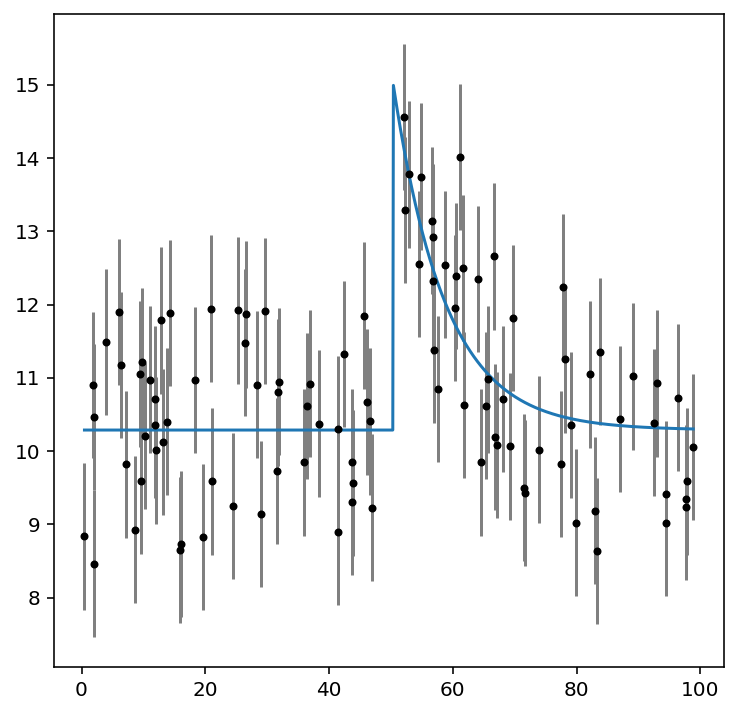

In [7]:
fig = plt.figure(figsize = (6,6))
plt.errorbar(time, flux, yerr = uncertanties, fmt = '.k', ecolor = 'gray')
x_fit = np.linspace(min(time), max(time), 1000)
plt.plot(x_fit, model(x_fit, popt[0], popt[1], popt[2], popt[3]))

In [8]:
def log_likelihood(theta, time, flux, uncertanties):
    
    b, A, a, t_0 = theta
    
    return -0.5 * np.sum((flux - model(time, b, A, a, t_0)) ** 2 / uncertanties + np.log(uncertanties))

def log_prior(theta):
    
    b, A, a, t_0 = theta
    
    if 0.0 < b < 50.0 and 0.0 < A < 50.0 and 0.0 < t_0 < 100.0 and -5.0 < np.log(a) < 5.0:
        return 0.0 - np.log(a)
    
    return -np.inf

def log_probability(theta, time, flux, uncertanties):
    
    b, A, a, t_0 = theta
    
    lp = log_prior(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, uncertanties)

In [9]:
pos = popt + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args = (time, flux, uncertanties)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:08<00:00, 562.70it/s]


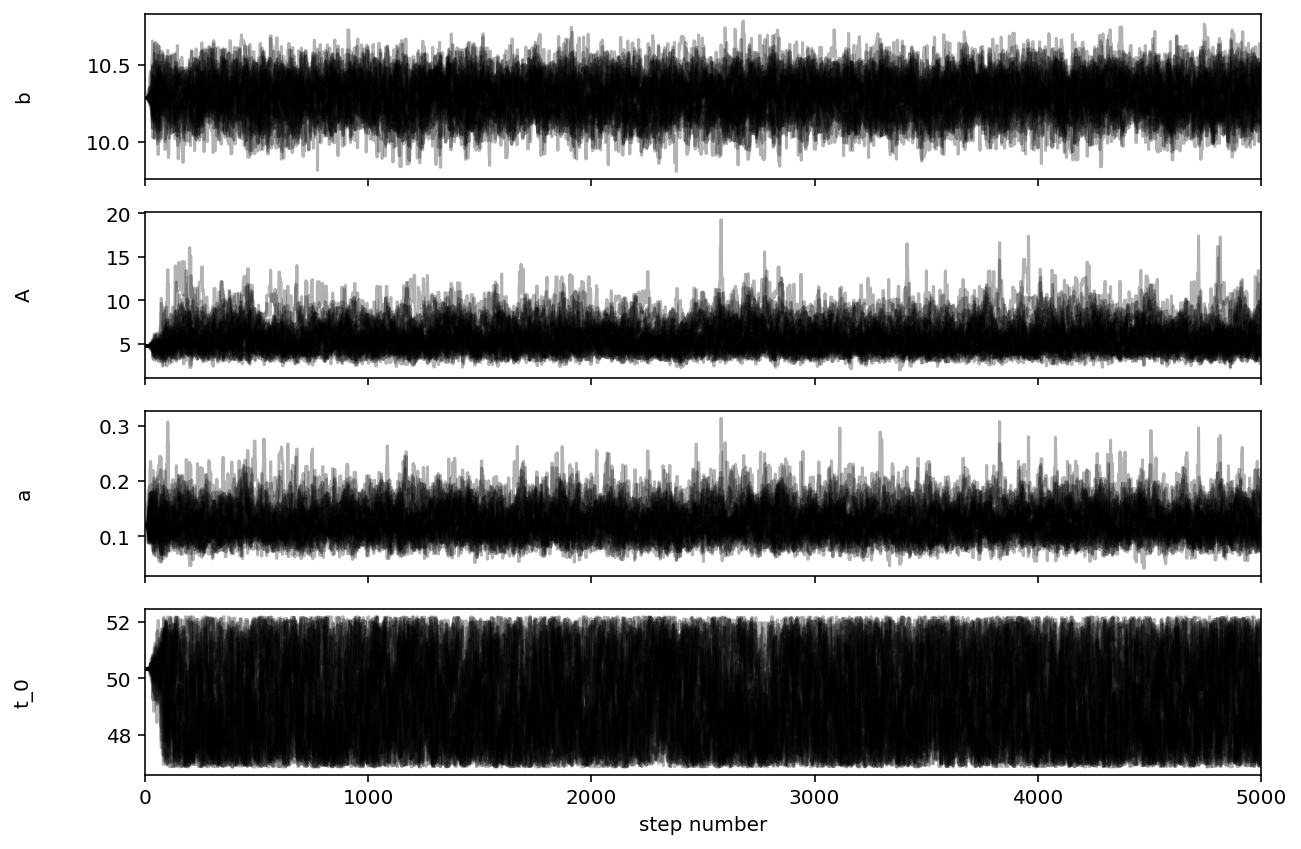

In [10]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["b", "A", "a", "t_0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [11]:
tau = sampler.get_autocorr_time()
print(tau)

[48.58370228 57.76854544 53.28651027 65.98326732]


In [12]:
flat_samples = sampler.get_chain(discard=100, thin = int(np.mean(tau)), flat=True)
print(flat_samples.shape)

(2784, 4)


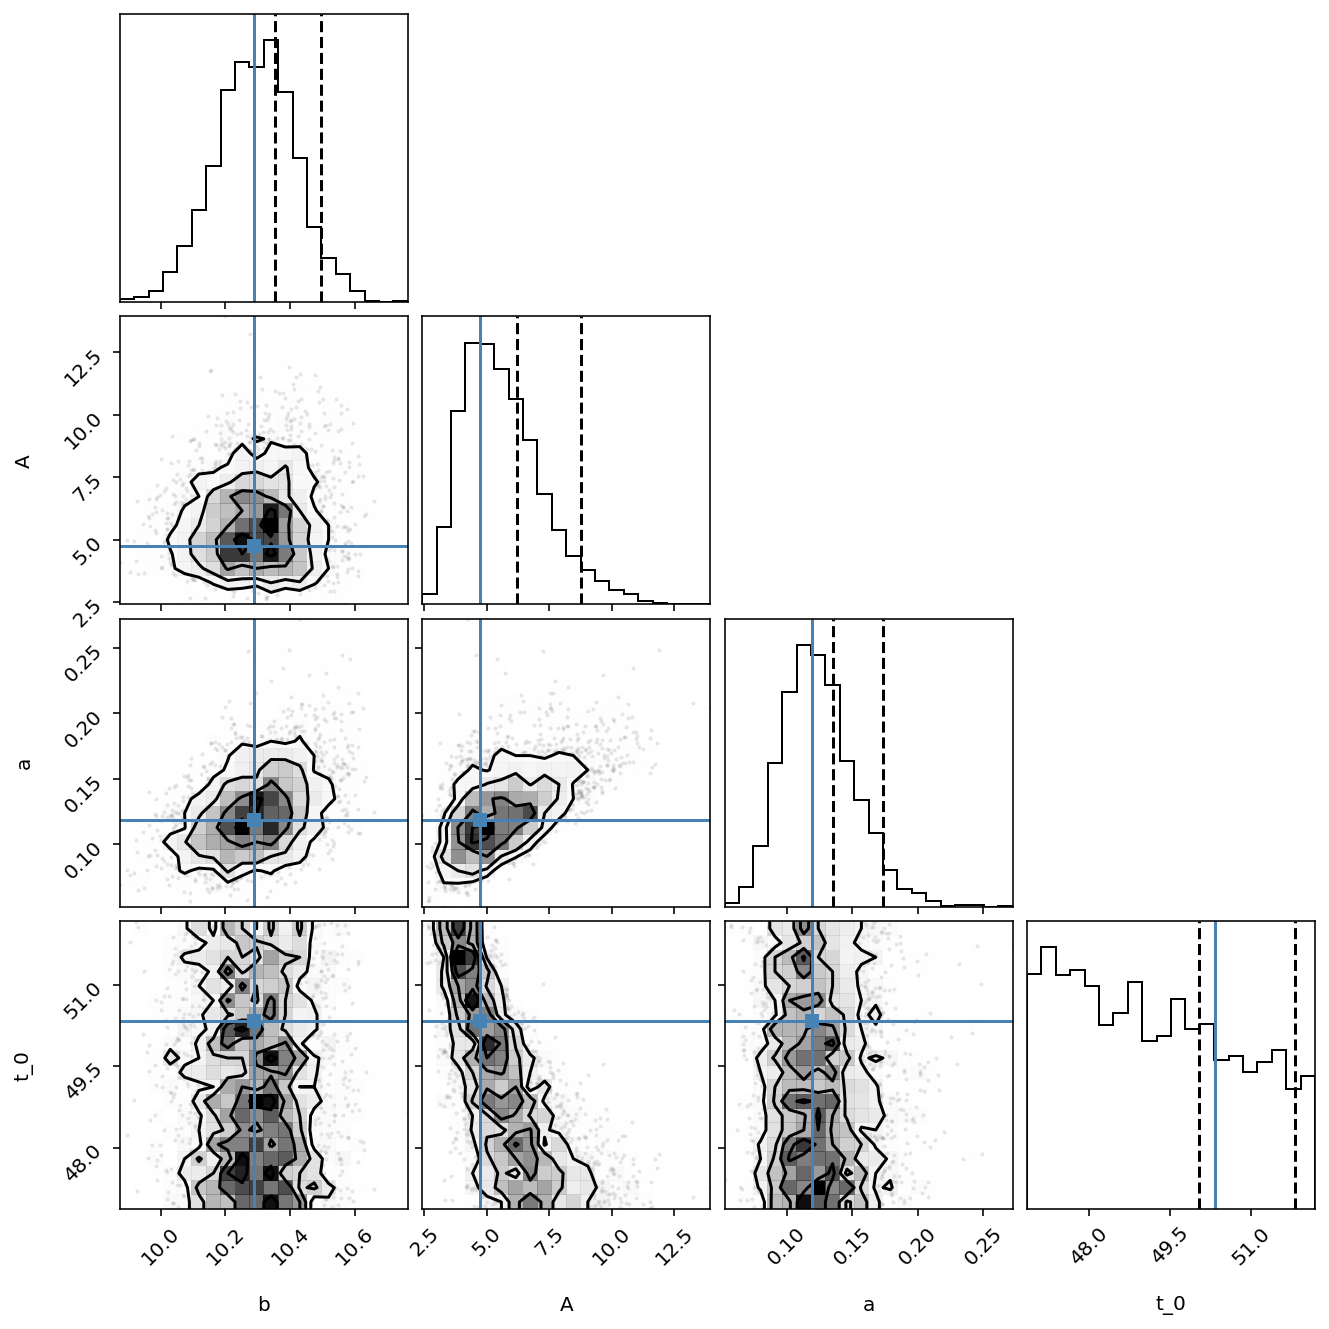

In [13]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[popt[0], popt[1], popt[2], popt[3]], quantiles = [68/100, 95/100]
);

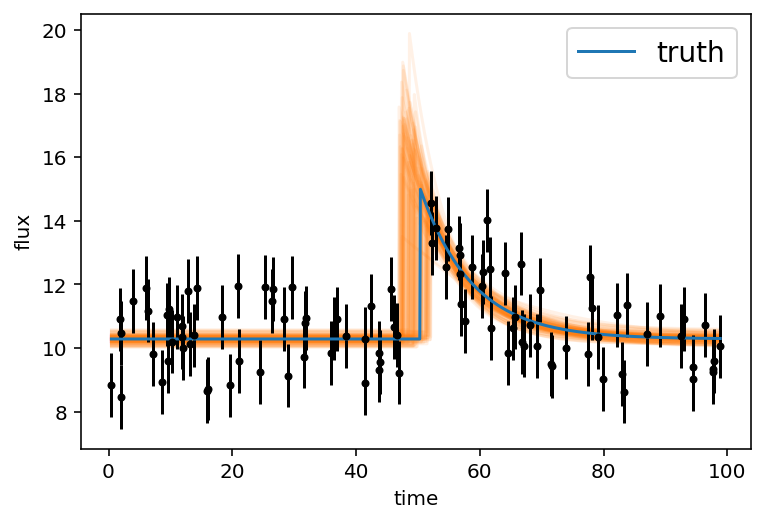

In [14]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x_fit, model(x_fit, sample[0], sample[1], sample[2], sample[3]), "C1", alpha=0.1)
    
plt.errorbar(time, flux, yerr=uncertanties, fmt=".k", capsize=0)
plt.plot(x_fit, model(x_fit, popt[0], popt[1], popt[2], popt[3]), label="truth")
plt.legend(fontsize=14)

plt.xlabel("time")
plt.ylabel("flux");

In [15]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
#These doesn't represent the best model parameters, but they are statistics of the marginalized distributions

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Nested Sampling

In [16]:
popt, pcov = optimize.curve_fit(model, time, flux, p0 = [10.3, 5.4, 0.1, 49.2], sigma = uncertanties)

In [17]:
# Define the dimensionality of our problem.
ndim = 4

In [18]:
def log_likelihood(theta, time, flux, uncertanties):
    
    b, A, a, t_0 = theta
    
    # Note I'm not tracking the normalization here! 
    # Ok because here I only care about the ratio between two evidences, not the evidence itself
    return -0.5 * np.sum((flux - model(time, b, A, a, t_0)) ** 2 / uncertanties + np.log(uncertanties))
 
# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our prior for each variable."""
    
    b = uniform.ppf(u[0], 0, 50) 
    A = uniform.ppf(u[1], 0, 50)
    a = np.exp(uniform.ppf(u[2], -5, 5))
    t_0 = uniform.ppf(u[3], 0, 100)

    return [b, A, a, t_0]

In [21]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim, logl_args=[time, flux, uncertanties], nlive=300)
sampler.run_nested()
sresults = sampler.results

4728it [01:26, 54.72it/s, +300 | bound: 141 | nc: 1 | ncall: 74072 | eff(%):  6.816 | loglstar:   -inf < -48.766 <    inf | logz: -63.247 +/-  0.213 | dlogz:  0.001 >  0.309]


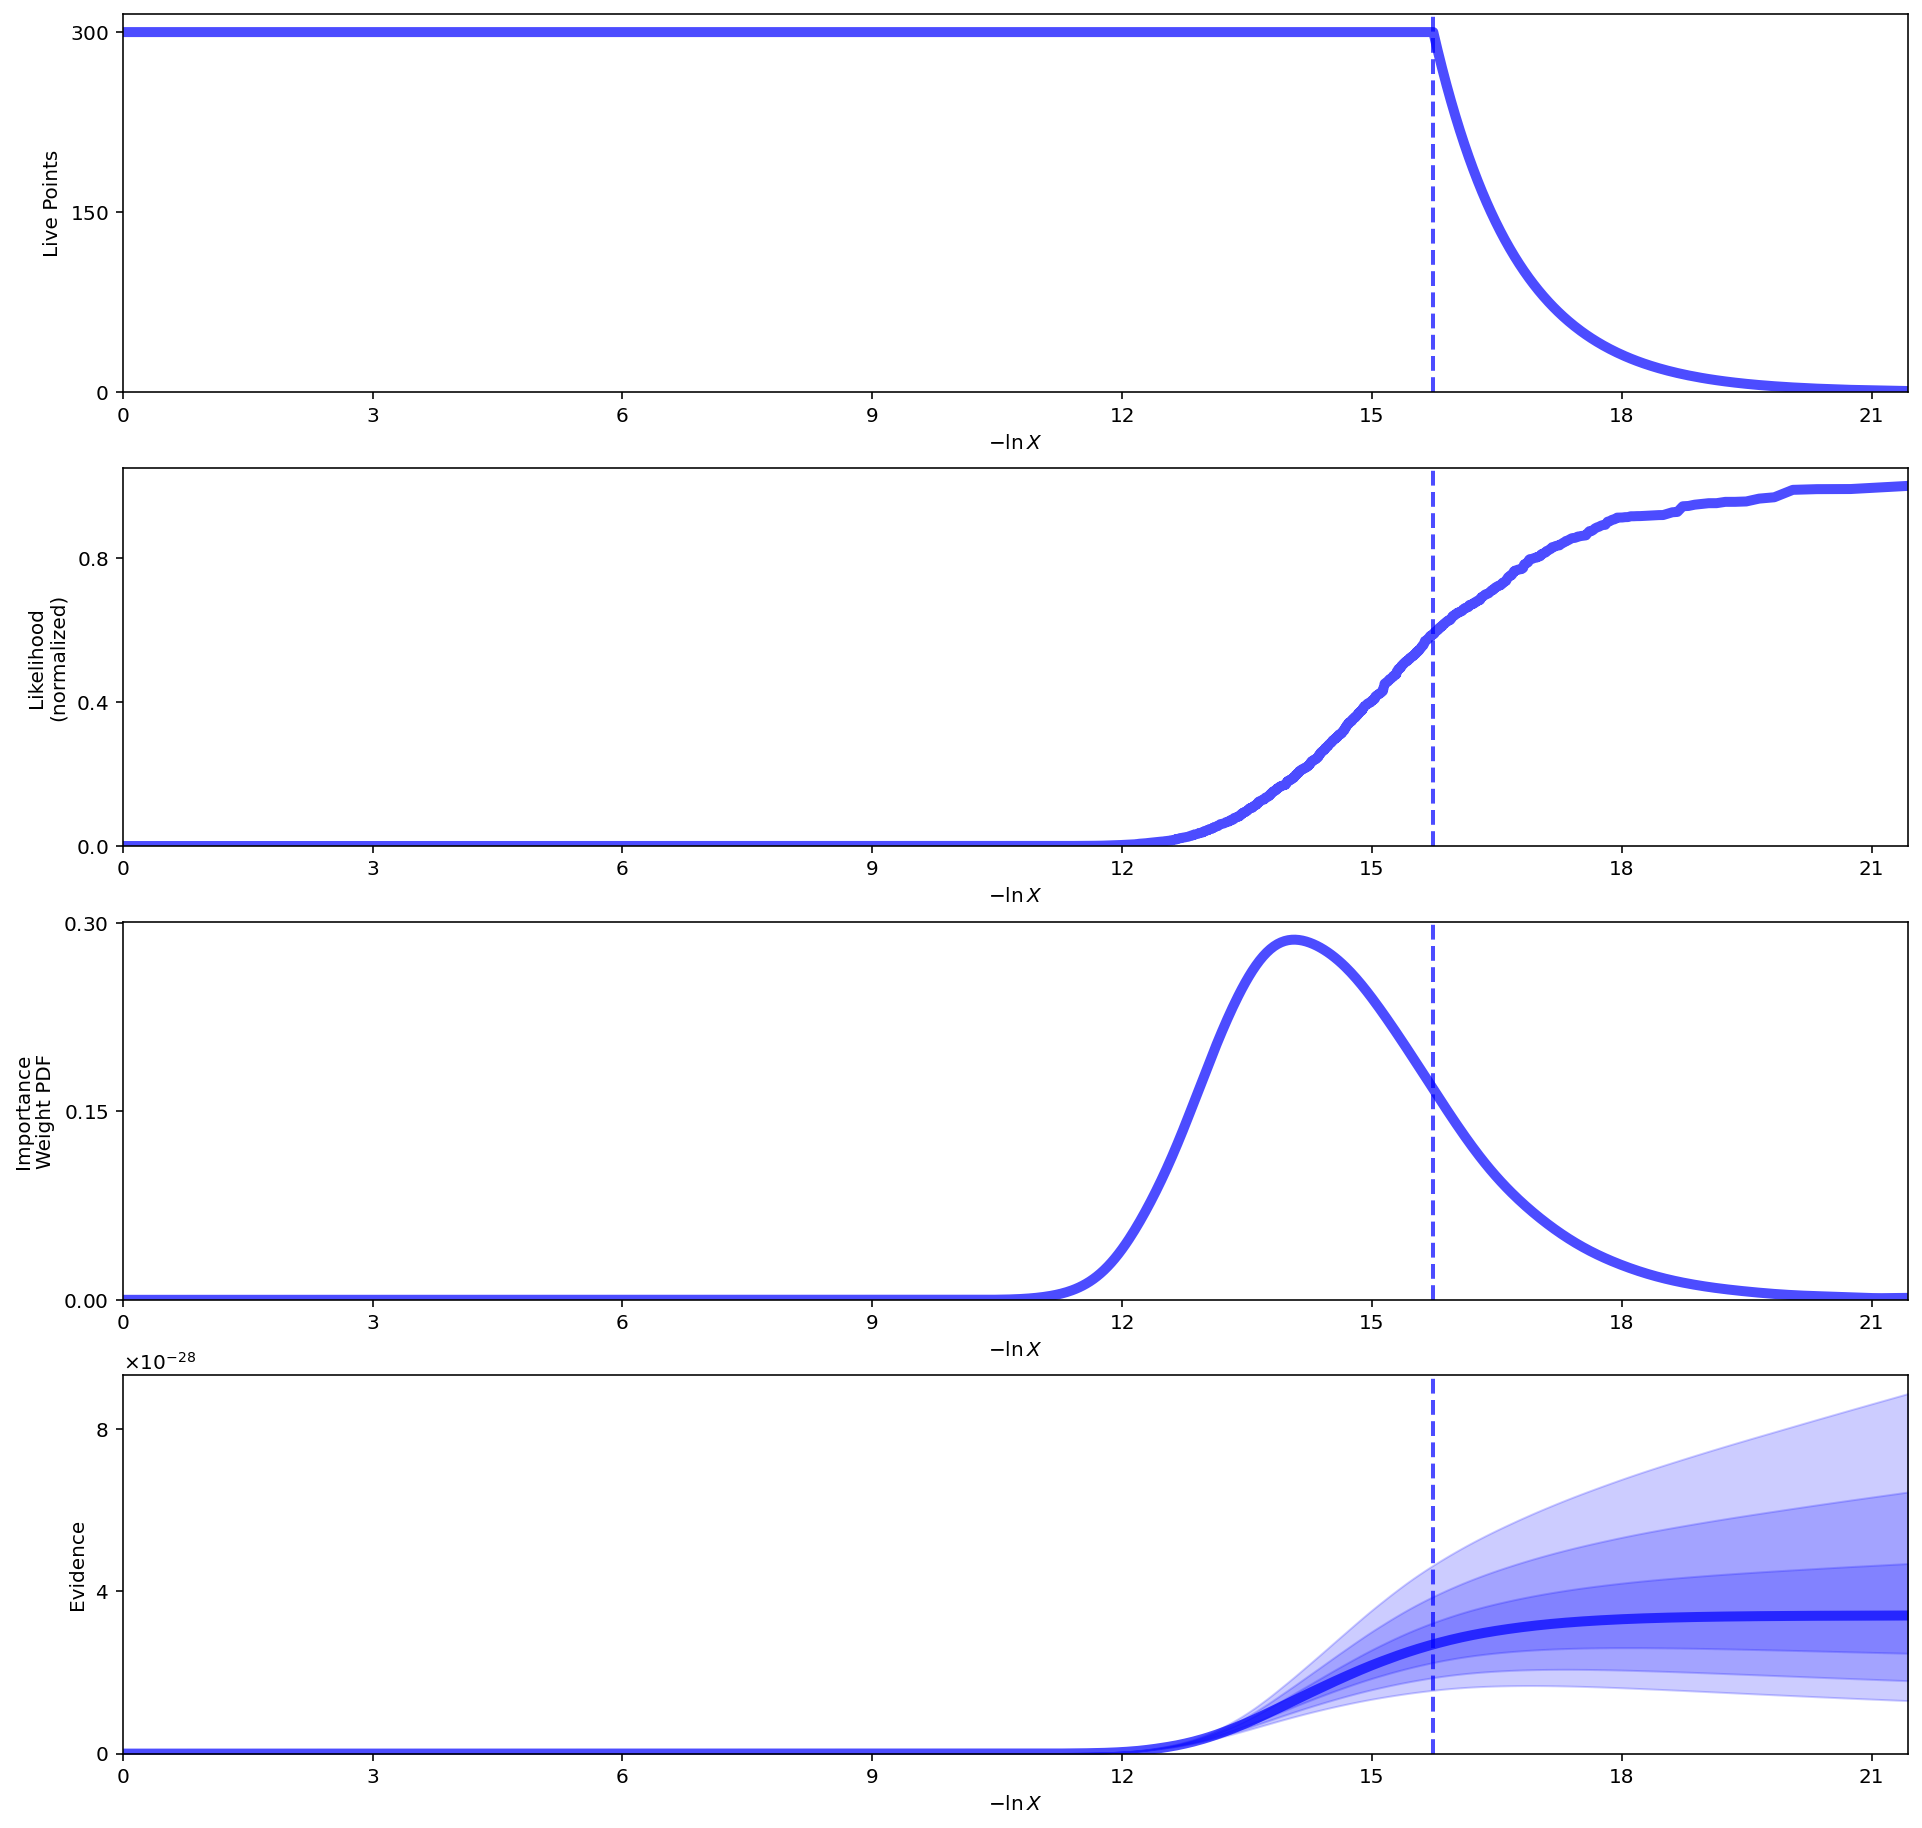

In [22]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

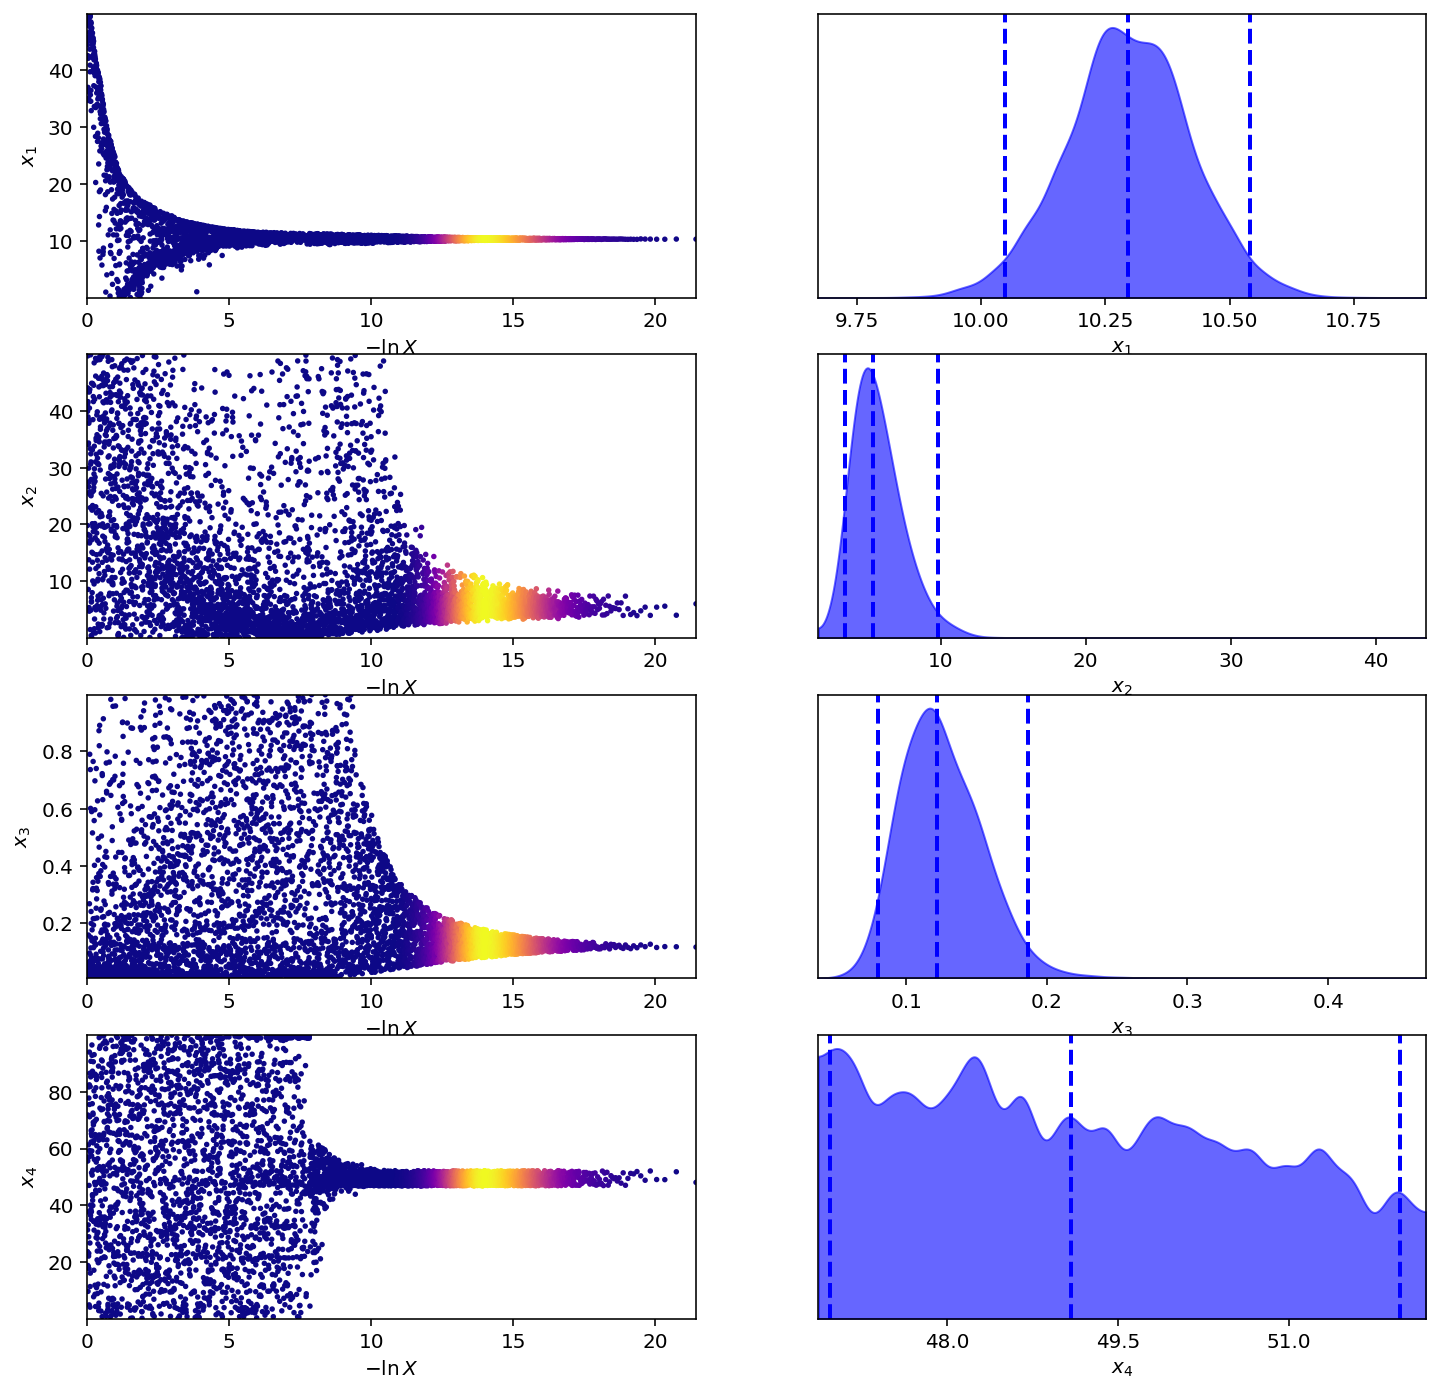

In [23]:
tfig, taxes = dyplot.traceplot(sresults)

In [24]:
from dynesty import utils as dyfunc


# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.10, 0.90], weights=weights)
             for samps in samples.T]
print('90% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 3.404778490016978e-28
90% parameter credible regions are:
 [[10.139056520834426, 10.455045272008268], [3.9106839915584213, 7.940208491362738], [0.09195436362607164, 0.16261537811835086], [47.23913556485182, 51.38527632024002]]

Mean and covariance of parameters are: [10.29660967  5.68656281  0.12550025 49.22355647]
[[ 1.52981453e-02  1.42725262e-02  1.27329892e-03 -5.36908548e-03]
 [ 1.42725262e-02  2.76612885e+00  2.85556959e-02 -1.63576435e+00]
 [ 1.27329892e-03  2.85556959e-02  8.13011845e-04 -1.54480012e-03]
 [-5.36908548e-03 -1.63576435e+00 -1.54480012e-03  2.24585295e+00]]


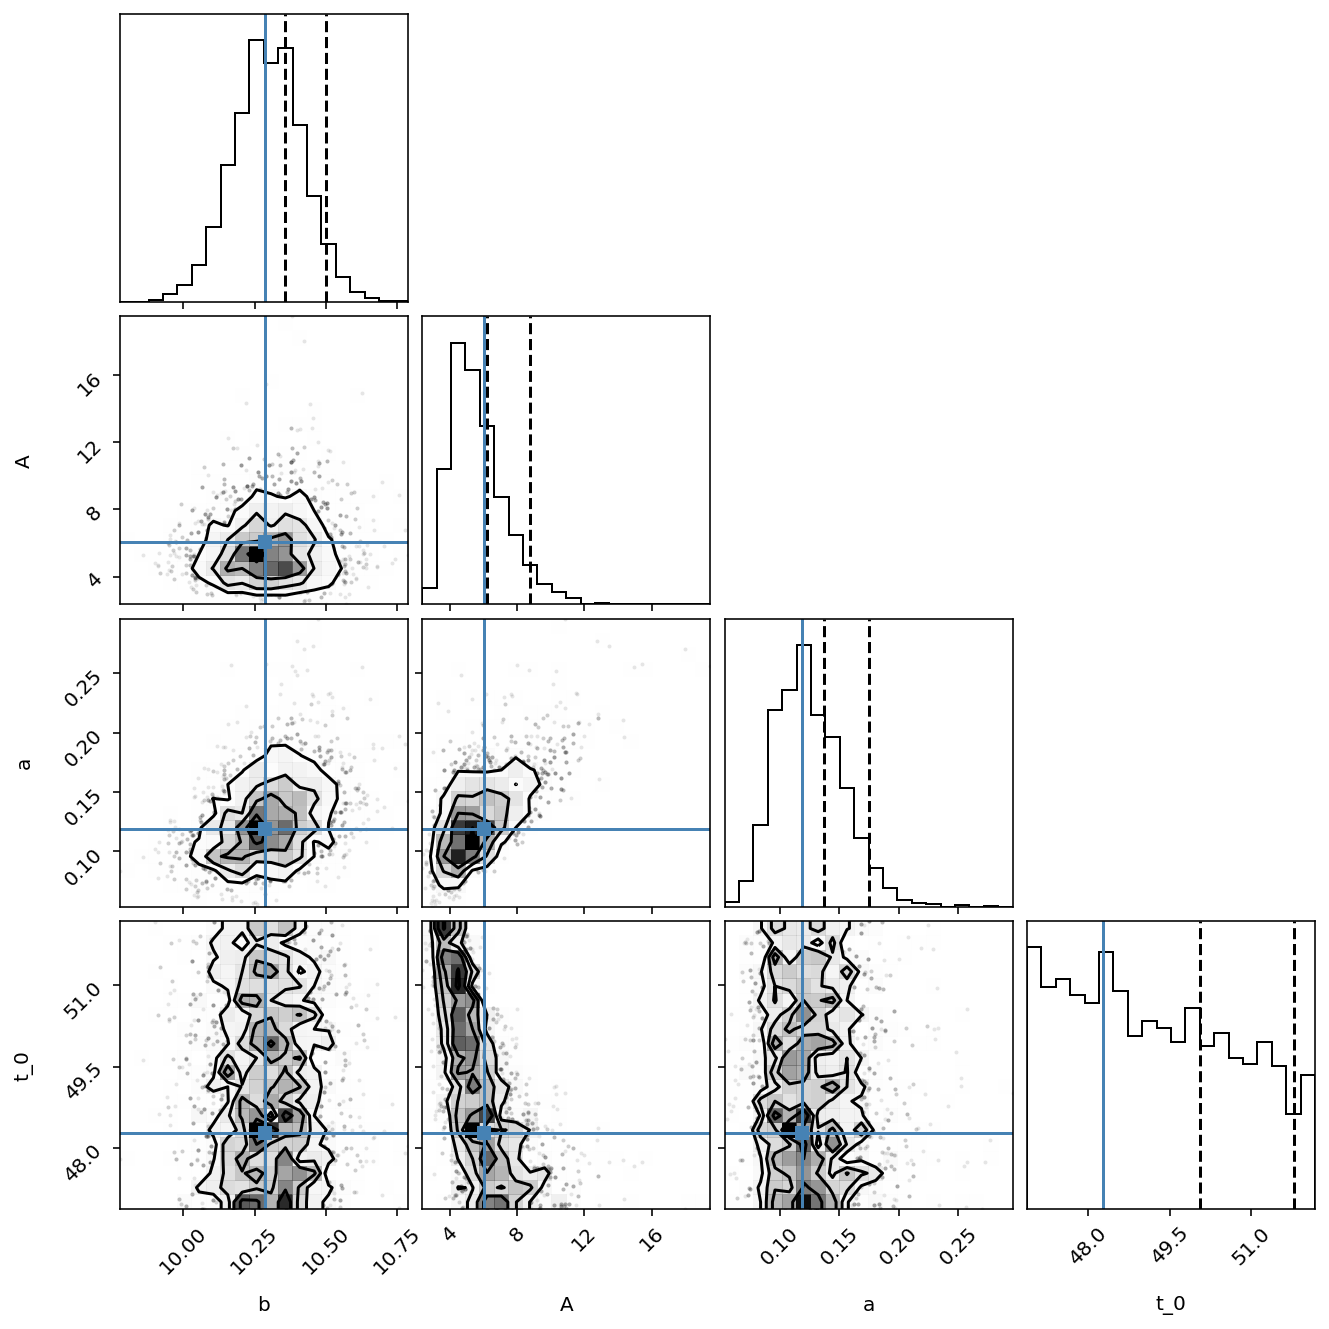

In [25]:
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal, labels=labels, truths=[popt[0], popt[1], popt[2], popt[3]], quantiles = [68/100, 95/100]);

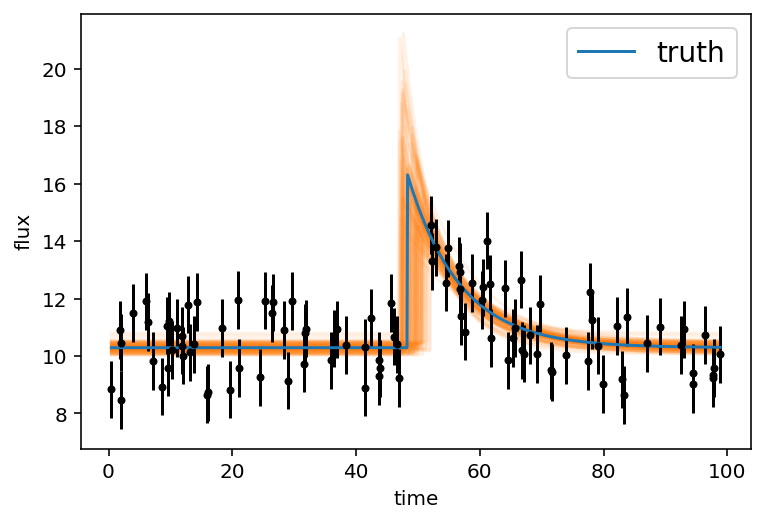

In [26]:
inds = np.random.randint(len(samples_equal), size=100)
for ind in inds:
    sample = samples_equal[ind]
    plt.plot(x_fit, model(x_fit, sample[0], sample[1], sample[2], sample[3]), "C1", alpha=0.1)
    
plt.errorbar(time, flux, yerr=uncertanties, fmt=".k", capsize=0)
plt.plot(x_fit, model(x_fit, popt[0], popt[1], popt[2], popt[3]), label="truth")
plt.legend(fontsize=14)

plt.xlabel("time")
plt.ylabel("flux");

In [27]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples_equal[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>